In [55]:
import glob, os, sys
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

In [3]:
files = glob.glob('../data/iea_balances_public/*')

In [4]:
iso2 = pd.read_csv('../data/iso2.csv')

In [5]:
fiona.listlayers('../data/GHSL_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1.gpkg')

['GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1']

In [6]:
ghsl_gdf = gpd.read_file('../data/GHSL_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1.gpkg')

In [13]:
ghsl_gdf.GDP15_SM

0        5369555456
1        1881494016
2        4434151424
3         872692416
4        1209973248
            ...    
13130    1019849024
13131    3498342656
13132    1449215488
13133     975898880
13134             0
Name: GDP15_SM, Length: 13135, dtype: object

Want to add to the ghsl: 
- oil, gas, coal cons.
1. Need to expand the area of ghsl to include all of the given country. Creates a df with urban+rural populations
  - within each country, geovoronoi all the coords of each urban area. cascade union to get large urban+rural zones, add rural area back to dataframe. Can assume all rural popdens is the same per country, get rural pop from iso2
2. for each urban+rural combo, need to calculate oil, gas, and coal consumption. Parametrically estimate from Google EIE based on (pop density, HDD, CDD, [GDP/pop], IEA region) and scale to IEA.

THEN merge with countries not represented in the ghsl who each get their own region

In [12]:
ghsl_gdf.P15.astype('float').sum()

3535326298.542409

### Parametrically estimate from Google EIE

In [64]:
EIE_buildings = pd.read_csv('../data/google_EIE/buildings.csv')
EIE_general = pd.read_csv('../data/google_EIE/general.csv')
EIE_transport = pd.read_csv('../data/google_EIE/transport.csv')

In [65]:
iso2

,country,iso2,iso3,iso_num,region,region_IEA,region_IEA_secondary,region_IEA_final,urban_pop,rural_pop,population,portion
0,Afghanistan,AF,AFG,4.0,ASIA,DEVASIA,DEVASIA,DEVASIAXINCN,8547.0,23460.0,32007,0.028394
1,Aland Islands,AX,ALA,248.0,EUROPE,NaN,NaN,OTHER,NaN,NaN,0,0.000000
2,Albania,AL,ALB,8.0,EUROPE,TE,TE,TEXRU,1835.0,1362.0,3197,0.016215
3,Algeria,DZ,DZA,12.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,28739.0,11895.0,40634,0.038370
4,American Samoa,AS,ASM,16.0,ANZ-OCEANIA,OTHER,OTHER,OTHER,48.0,7.0,55,0.001792
...,...,...,...,...,...,...,...,...,...,...,...,...
244,Yemen,YE,YEM,887.0,MIDEAST,ME,ME,ME,8837.0,16698.0,25535,0.112631
245,Zambia,ZM,ZMB,894.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,6351.0,9169.0,15520,0.014655
246,Zimbabwe,ZW,ZWE,716.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,4871.0,10175.0,15046,0.014208
247,Dutch Carribean,BQ,BES,535.0,LATIN,NaN,NaN,OTHER,15.0,5.0,20,0.000652


In [66]:
EIE_general['iso2'] = EIE_general['COUNTRY'].astype('str')

In [67]:
EIE_general = EIE_general.join(iso2[['iso2','region_IEA_secondary']].set_index('iso2'), on='iso2')

In [74]:
EIE_buildings

,CITY,SECTOR,BUILDINGS,EMISSIONS,ELEC_INTENSITY,ELEC_FRACTION,ENERGY_INTENSITY,FLOORSPACE,FUEL_INT,FUEL_FRAC
0,Buenos Aires,Residential,235805,1319000,0.0004,0.5292,90.1052,45630000,0.0002,0.4708
1,Buenos Aires,Non-residential,60577,2409000,0.0004,0.7861,150.7102,44104000,0.0002,0.2139
2,Kyoto,Residential,475787,3549000,0.0006,0.4342,153.9420,61898000,0.0002,0.5658
3,Kyoto,Non-residential,58622,5212000,0.0006,0.6683,238.6454,48936000,0.0002,0.3317
4,Adelaide,Residential,489439,5064000,0.0004,0.4151,142.4763,110954000,0.0002,0.5849
...,...,...,...,...,...,...,...,...,...,...
231,Mexico City,Non-residential,170889,7482000,0.0005,0.7921,149.2302,122963000,0.0002,0.2079
232,Guadalajara,Residential,328786,1901000,0.0005,0.6940,98.1823,50103000,0.0002,0.3060
233,Guadalajara,Non-residential,43814,1340000,0.0005,0.8218,144.0624,22460000,0.0002,0.1782
234,Nuevo Leon,Residential,1879138,8646000,0.0005,0.7632,99.3499,213917000,0.0002,0.2368


In [69]:
EIE_general.region_IEA_secondary.unique()

array(['LAM', 'OECDPAC', 'OECDEUR', 'OECDAMS'], dtype=object)

In [70]:
cols_dict = {'LAM':'red',
            'OECDPAC':'pink',
            'OECDEUR':'green',
            'OECDAMS':'blue'}

In [71]:
EIE_general['color'] = EIE_general.region_IEA_secondary.map(cols_dict)

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


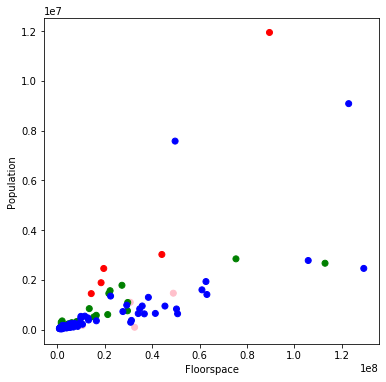

In [77]:
#floorspace per person
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_buildings[EIE_buildings.SECTOR=='Non-residential'].set_index('CITY').loc[EIE_general.CITY].FLOORSPACE,
    EIE_general.POPULATION.str.replace(',','').astype('float').values,
    c = EIE_general['color'].values
)
ax.set_ylabel('Population')
ax.set_xlabel('Floorspace')
plt.show()

In [78]:
EIE_buildings['FUEL_INTENSITY'] = EIE_buildings.ENERGY_INTENSITY * EIE_buildings.FUEL_FRAC

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


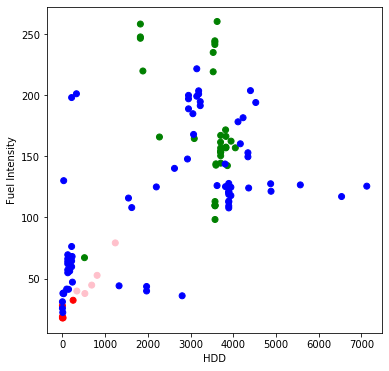

In [81]:
#hdd vs building energy
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_general.HDD,
    EIE_buildings[EIE_buildings.SECTOR=='Non-residential'].set_index('CITY').loc[EIE_general.CITY].FUEL_INTENSITY,
    c = EIE_general['color'].values
)
ax.set_ylabel('Fuel Intensity')
ax.set_xlabel('HDD')
plt.show()

In [89]:
#EIE_general = EIE_general.join(EIE_transport.groupby('CITY').EMISSIONS.sum(), on='CITY')
EIE_general = EIE_general.rename(columns={'EMISSIONS':'TRANSPORT_EMISSIONS'})

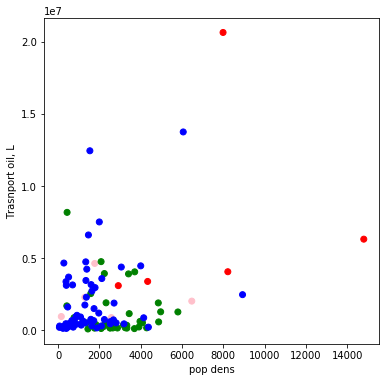

In [91]:
#transport vs pop dens
# petrol -> 2.3 kg/L
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_general.POP_DENS,
    EIE_general.TRANSPORT_EMISSIONS/2.3,
    c = EIE_general['color'].values
)
ax.set_ylabel('Trasnport oil, L')
ax.set_xlabel('pop dens')
plt.show()

In [ ]:
color by iea region:
hdd vs buildings
transport vs. pop density
pop dens vs floorspace